In [1]:
from pickle import load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
src, configs, n_params_, losses_accs_ = load(open('train_projection=64_epochs=100_lr=5e-4_sess=1.pickle', 'rb'))
srcf, configsf, n_params_f, losses_accs_f = load(open('train_projection=full_epochs=100_lr=5e-4_sess=1.pickle', 'rb'))

In [3]:
losses_accs_df = list(map(lambda x: pd.DataFrame(x), losses_accs_))
losses_accs_fdf = list(map(lambda x: pd.DataFrame(x), losses_accs_f))

In [27]:
def attention_head(n_tokens, dim, dim_head):
    macs = 0
    
    # token -> k, q, v
    macs += n_tokens * 3 * dim * dim_head
    
    # q * k'
    # (n_tokens, dim_head) * (dim_head, n_tokens) -> (n_tokens, n_tokens)
    macs += n_tokens * dim_head * n_tokens
    
    # Softmax e diviso sqrt(dim_head) 
    # ...
    
    # (q * k') * v
    # (n_tokens, n_tokens) * (n_tokens, dim_head) -> (n_tokens, dim_head)
    macs += n_tokens * n_tokens * dim_head
    
    return macs
    
def attention(n_tokens, dim, dim_head, n_heads):
    macs = 0
    
    macs += n_heads * attention_head(n_tokens, dim, dim_head)
    
    # Riporta gli z concatenati a dimensione dim
    macs += n_tokens * (dim_head * n_heads) * dim if not (n_heads == 1 and dim_head == dim) else 0
    
    return macs

def feed_forward(n_tokens, dim, mlp_dim):
    # 2 Linear: dim -> mlp_dim, mlp_dim -> dim
    return n_tokens * dim * mlp_dim * 2

def MACs_ratio(image_size, patch_size, dim, dim_head, heads, mlp_dim, **ignore):
    n_tokens = image_size[-1] // patch_size[-1] + 1
    a = attention(n_tokens, dim, dim_head, heads)
    f = feed_forward(n_tokens, dim, mlp_dim)
    
    return a / (f+a)

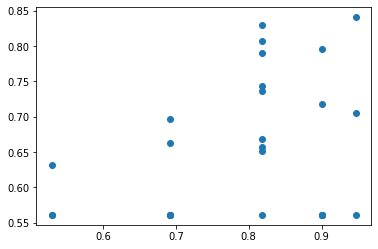

In [42]:
macs_ratios = [MACs_ratio(**config) for config in configs]
plt.scatter(macs_ratios, [losses_accs_df[i].val_acc.max() for i in range(len(losses_accs_df))])

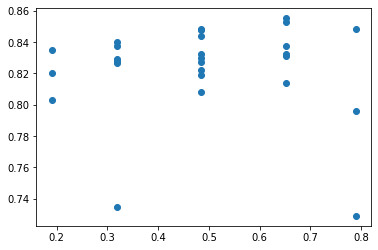

In [41]:
macs_ratios = [MACs_ratio(**config) for config in configsf]
plt.scatter(macs_ratios, [losses_accs_fdf[i].val_acc.max() for i in range(len(losses_accs_fdf))])

In [36]:
def params_ratio(image_size, patch_size, dim, dim_head, heads, mlp_dim, **ignore):
    n_tokens = image_size[-1] // patch_size[-1] + 1
    
    a = 3 * dim * dim_head
    
    f = (dim_head * heads) * dim + dim * mlp_dim * 2
    
    return a / (f+a)

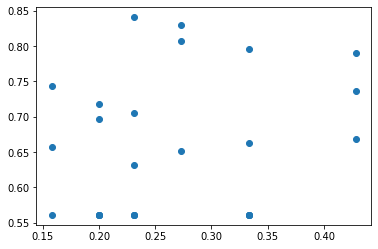

In [40]:
params_ratios = [params_ratio(**config) for config in configs]
plt.scatter(params_ratios, [losses_accs_df[i].val_acc.max() for i in range(len(losses_accs_df))])

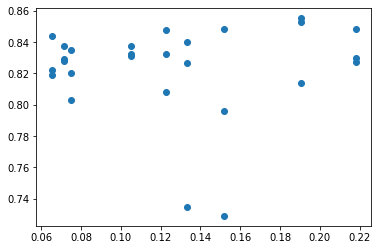

In [39]:
params_ratios = [params_ratio(**config) for config in configsf]
plt.scatter(params_ratios, [losses_accs_fdf[i].val_acc.max() for i in range(len(losses_accs_fdf))])

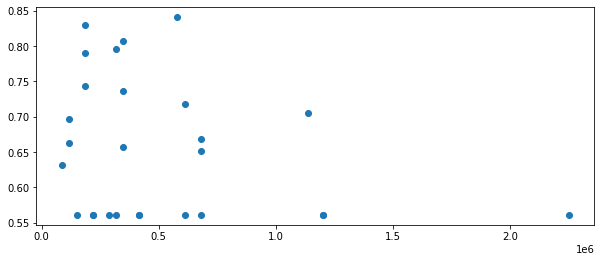

In [43]:
plt.figure(figsize=(10, 4))
plt.scatter(n_params_, [losses_accs_df[i].val_acc.max() for i in range(len(losses_accs_df))])

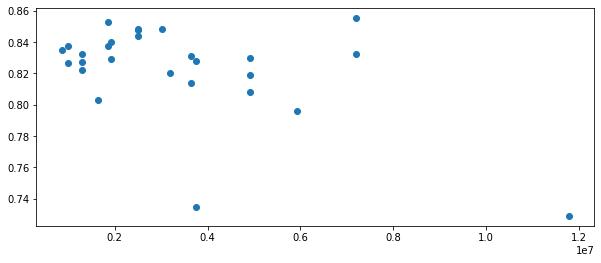

In [44]:
plt.figure(figsize=(10, 4))
plt.scatter(n_params_f, [losses_accs_fdf[i].val_acc.max() for i in range(len(losses_accs_fdf))])